# CH4 Time Series Forecasting
**Objective**: Validate selected model on test data and forecast atmospheric methane concentration

## Input Data
1. 'data/processed/CH4_train_log_preprocessed.csv'
2. 'data/processed/CH4_test_log_preprocessed.csv'

## Model Configuration
- (7,1,0)(1,1,1,52): 'results/CH4_train_best_model_config.json'
- (1,1,1)(0,1,1,52): 'results/CH4_train_best_simple_model_config.json'

## Stages
1. load data and saved model configurations
2. rebuild and re-fit SARIMA model
3. generate out-of-sample forecasts
4. calculate test metrics
5. output: validation report

In [10]:
import sys
from pathlib import Path

# print absolute path to forecast_metrics.py
fm_path = Path.cwd().parent / 'src' / 'forecast_metrics.py'
print(f'Expected file path: {fm_path}')
print(f'File exists: {fm_path.exists()}')

Expected file path: C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\src\forecast_metrics.py
File exists: True


In [11]:
# enable auto-reloading of imported modules
%load_ext autoreload
%autoreload 2

# add both repo root and src/ to path
repo_root = Path.cwd().parent
 
sys.path.insert(0, str(repo_root))
sys.path.insert(0, str(repo_root / 'src')) 

# verify paths
print('\nPython Paths:')
for p in sys.path[:3]:
    print(f'--> {p}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Python Paths:
--> C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\src
--> C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting
--> C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\src


# Libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from src.forecast_metrics import forecast_metrics
print('forecast_metrics imported sucessfully!')

forecast_metrics imported sucessfully!


# Load the Data

In [13]:
# load the preprocessed train and test data (from ../data/processed/), and explicity set the frequency
CH4_train_preprocessed = pd.read_csv(
    '../data/processed/CH4_train_preprocessed.csv',
    parse_dates=['date'], 
    index_col='date'
)

CH4_train_preprocessed.index = pd.DatetimeIndex(CH4_train_preprocessed.index, freq='W-SUN')

CH4_test_preprocessed = pd.read_csv(
    '../data/processed/CH4_test_preprocessed.csv',
    parse_dates=['date'],
    index_col='date'
)

CH4_test_preprocessed.index = pd.DatetimeIndex(CH4_test_preprocessed.index, freq='W-SUN')

# load the logged train and test data (from ../data/processed/), and explicity set the frequency
CH4_train_log_preprocessed = pd.read_csv(
    '../data/processed/CH4_train_log_preprocessed.csv',
    parse_dates=['date'],
    index_col='date'
)

CH4_train_log_preprocessed.index = pd.DatetimeIndex(CH4_train_log_preprocessed.index, freq='W-SUN')

# force a numeric conversion (due to issues with saving data to csv)
CH4_train_log_preprocessed['log_ch4'] = pd.to_numeric(CH4_train_log_preprocessed['log_ch4'], errors='coerce')

CH4_test_log_preprocessed = pd.read_csv(
    '../data/processed/ch4_test_log_preprocessed.csv',
    parse_dates=['date'],
    index_col='date'
)

CH4_test_log_preprocessed.index = pd.DatetimeIndex(CH4_test_log_preprocessed.index, freq='W-SUN')

# force a numueric conversion (due to issues with saving data to csv)
CH4_test_log_preprocessed['log_ch4'] = pd.to_numeric(CH4_test_log_preprocessed['log_ch4'], errors='coerce')

In [14]:
CH4_train_preprocessed.head()

CH4
date                  
1983-05-08  1637.32925
1983-05-15  1645.17000
1983-05-22  1645.17000
1983-05-29  1637.32925
1983-06-05  1630.24525

In [15]:
CH4_test_preprocessed.head()

CH4
date                 
2023-10-29  1954.9125
2023-11-05  1954.9125
2023-11-12  1954.8800
2023-11-19  1946.6300
2023-11-26  1946.6625

In [16]:
CH4_train_log_preprocessed.head()

log_ch4
date               
1983-05-08  7.40081
1983-05-15  7.40560
1983-05-22  7.40560
1983-05-29  7.40081
1983-06-05  7.39649

In [17]:
CH4_test_log_preprocessed.head()

log_ch4
date               
2023-10-29  7.57810
2023-11-05  7.57810
2023-11-12  7.57808
2023-11-19  7.57385
2023-11-26  7.57386

In [18]:
# Verify the data reloaded correctly
print("Training data shape after reload:", CH4_train_log_preprocessed.shape)
print("Test data shape after reload:", CH4_test_log_preprocessed.shape)

# Check the last training point vs first test point
print("Last training date:", CH4_train_log_preprocessed.index[-1])
print("First test date:", CH4_test_log_preprocessed.index[0])
print("Gap between train end and test start:", CH4_test_log_preprocessed.index[0] - CH4_train_log_preprocessed.index[-1])

Training data shape after reload: (2112, 1)
Test data shape after reload: (63, 1)
Last training date: 2023-10-22 00:00:00
First test date: 2023-10-29 00:00:00
Gap between train end and test start: 7 days 00:00:00


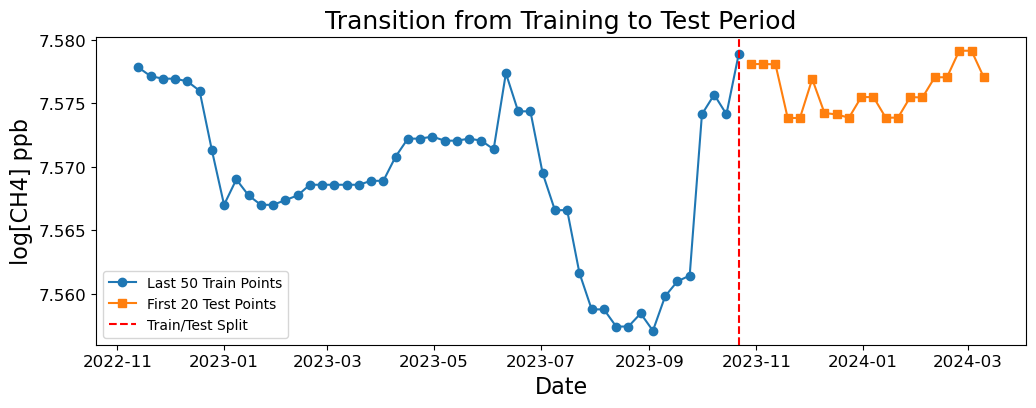

In [19]:
# Plot the transition from train to test
plt.figure(figsize=(12,4))
plt.plot(CH4_train_log_preprocessed.index[-50:], CH4_train_log_preprocessed.values[-50:], 
         label='Last 50 Train Points', marker='o')
plt.plot(CH4_test_log_preprocessed.index[:20], CH4_test_log_preprocessed.values[:20],
         label='First 20 Test Points', marker='s')
plt.axvline(x=CH4_train_log_preprocessed.index[-1], color='red', linestyle='--', 
            label='Train/Test Split')
plt.legend()
plt.title('Transition from Training to Test Period', fontsize=18)
plt.ylabel('log[CH4] ppb', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

# Load the model configuration and re-fit model

In [20]:
import json

with open('../results/CH4_train_best_model_config.json', 'r') as f:
    config = json.load(f)

model = SARIMAXResults.load('../results/CH4_best_sarima.pkl')

In [21]:
# Rebuild and re-fit model
try:
    model = SARIMAX(
        CH4_train_log_preprocessed,
        order=config['order'],
        seasonal_order=config['seasonal_order'],
        trend=config.get('trend', 'c'),
        enforce_stationarity=config.get('enforce_stationarity', True),
        enforce_invertibility=config.get('enforce_invertibility', True)
    )

    CH4_model_results = model.fit(method=config['fit_method'])

    print(f"Model re-fitted using data from {config['training_data_range']['start']} to {config['training_data_range']['end']}")

except Exception as e:
    print(f'Error refitting model: {e}')

Optimization terminated successfully.
         Current function value: -3.052991
         Iterations: 3
         Function evaluations: 401
Model re-fitted using data from 1983-05-08 to 2023-10-22


In [22]:
# verify the model order and seasonal order
print('"CH4_best_sarima": SARIMA(1,1,0)(1,0,0)[52]')
print('Order (p, d, q):', model.order)
print('Seasonal order (P, D, Q, s):', model.seasonal_order)

"CH4_best_sarima": SARIMA(1,1,0)(1,0,0)[52]
Order (p, d, q): (7, 1, 0)
Seasonal order (P, D, Q, s): (1, 1, 1, 52)


# Forecast the CH4 time series data

In [23]:
# forecast the CH4 best SARIMA model results: SARIMA(7,1,0)(1,1,1)[52], trend = 'c', method = 'powell'

# create the forecast object  
forecast_object = CH4_model_results.get_forecast(steps=len(CH4_test_preprocessed))

# get mean forecast and confidence intervals
forecast_logged = forecast_object.predicted_mean
forecast_conf_int_logged= forecast_object.conf_int()

# undo log (exponentiate), back-transform the logged values to original scale
forecast = np.exp(forecast_logged)
forecast_conf_int = np.exp(forecast_conf_int_logged)

# set the forecast index to match the test set index
forecast.index = CH4_test_preprocessed.index
forecast_conf_int.index = CH4_test_preprocessed.index

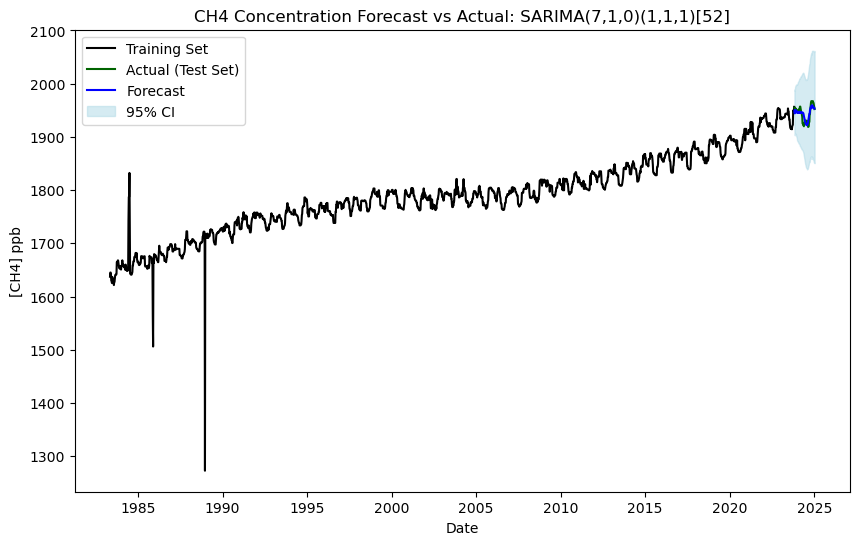

In [24]:
# plot the forecast results

plt.figure(figsize=(10,6))
plt.plot(CH4_train_preprocessed.index, CH4_train_preprocessed, label='Training Set', color='black')
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed, label='Actual (Test Set)', color='darkgreen') 
plt.plot(forecast.index, forecast, label='Forecast', color='blue') 
plt.fill_between(
    forecast_conf_int.index, 
    forecast_conf_int.iloc[:, 0], 
    forecast_conf_int.iloc[:, 1], 
    color='lightblue', alpha=0.5, label='95% CI'
)
plt.legend()
plt.title('CH4 Concentration Forecast vs Actual: SARIMA(7,1,0)(1,1,1)[52]') 
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.show()

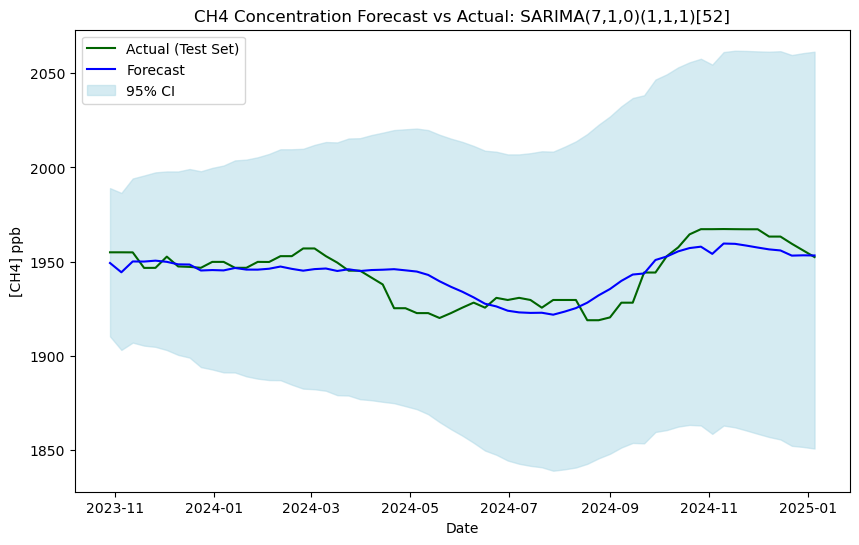

In [25]:
# focus on the forecast results

plt.figure(figsize=(10,6))
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed, label='Actual (Test Set)', color='darkgreen') 
plt.plot(forecast.index, forecast, label='Forecast', color='blue') 
plt.fill_between(
    forecast_conf_int.index, 
    forecast_conf_int.iloc[:, 0], 
    forecast_conf_int.iloc[:, 1], 
    color='lightblue', alpha=0.5, label='95% CI'
)
plt.legend()
plt.title('CH4 Concentration Forecast vs Actual: SARIMA(7,1,0)(1,1,1)[52]') 
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.show()

In [26]:
# Forecast metrics

print('Min and Max values of the CH4 test set to help interpret evaluation metrics')
print('(units = ppb)\n')
print('Min:', round(CH4_test_preprocessed.min(),3))
print('Max:', round(CH4_test_preprocessed.max(),3))
print('Range:', round(CH4_test_preprocessed.max() - CH4_test_preprocessed.min(),3))

print('\nEvaluation Metrics for SARIMA Predication (7,1,0)(1,1,1,52)')  
forecast_metrics(CH4_test_preprocessed, forecast)

Min and Max values of the CH4 test set to help interpret evaluation metrics
(units = ppb)

Min: CH4    1918.85
dtype: float64
Max: CH4    1967.268
dtype: float64
Range: CH4    48.418
dtype: float64

Evaluation Metrics for SARIMA Predication (7,1,0)(1,1,1,52)


{'MAE': 7.113, 'MSE': 80.525, 'RMSE': 8.974, 'MAPE': 0.367}

In [27]:
# Make sure both have the same index and are aligned
CH4_test_preprocessed, forecast_conf_int = CH4_test_preprocessed.align(forecast_conf_int, join='inner', axis=0)

# Extract the lower and upper CI bounds
lower = forecast_conf_int.iloc[:, 0]
upper = forecast_conf_int.iloc[:, 1]

# Boolean mask: whether actual values fall inside the 95% CI
inside = (CH4_test_preprocessed.squeeze() >= lower) & (CH4_test_preprocessed.squeeze() <= upper)

# Calculate proportion of points inside the interval
coverage = inside.mean() * 100
print(f"CI coverage: {coverage:.1f}%")

CI coverage: 100.0%


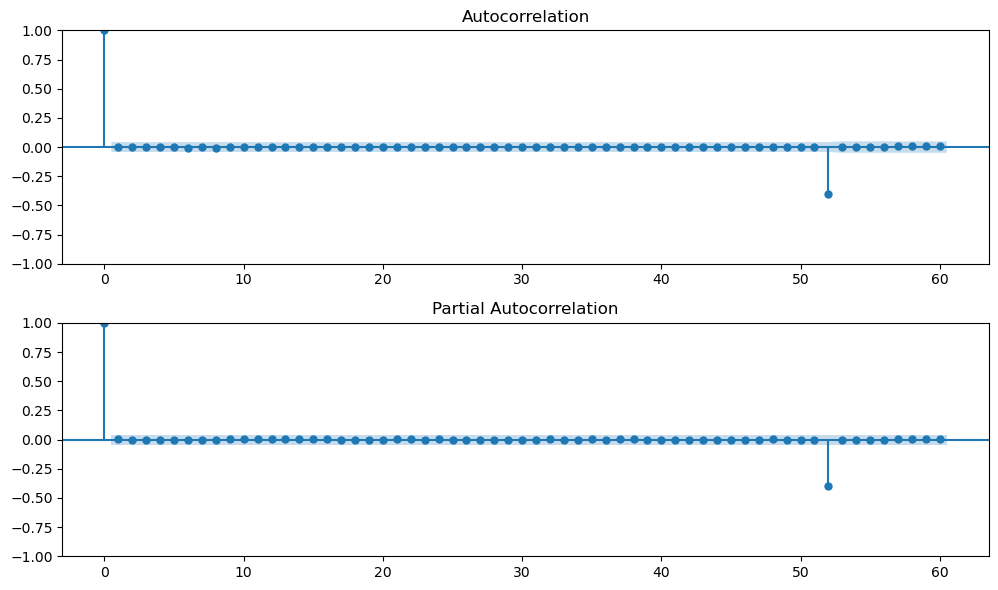

       lb_stat     lb_pvalue
12    0.123417  1.000000e+00
24    0.156871  1.000000e+00
36    0.161573  1.000000e+00
52  344.267433  1.039776e-44


In [28]:
# in-sample residual diagnostics (ACF/PACF, Ljung–Box)

import statsmodels.api as sm

resid = CH4_model_results.resid  # residuals from fitted SARIMA (in log-space if you fit log)
fig, ax = plt.subplots(2,1, figsize=(10,6))
sm.graphics.tsa.plot_acf(resid.dropna(), ax=ax[0], lags=60)
sm.graphics.tsa.plot_pacf(resid.dropna(), ax=ax[1], lags=60)
plt.tight_layout()
plt.show()

# Ljung-Box test for no autocorrelation at multiple lags
lb = sm.stats.acorr_ljungbox(resid.dropna(), lags=[12,24,36,52], return_df=True)
print(lb)

In [29]:
# Check parameter significance and model stability

print(CH4_model_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              log_ch4   No. Observations:                 2112
Model:             SARIMAX(7, 1, 0)x(1, 1, [1], 52)   Log Likelihood                6447.918
Date:                              Wed, 15 Oct 2025   AIC                         -12873.836
Time:                                      13:25:42   BIC                         -12811.906
Sample:                                  05-08-1983   HQIC                        -12851.130
                                       - 10-22-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.601e-06   6.96e-05     -0.037      0.970      -0.000       0.000
ar.L1         -0.64

In [30]:
# Check for ARCH effects (conditional heteroscedasticity)

from statsmodels.stats.diagnostic import het_arch

resid = CH4_model_results.resid.dropna()
arch_test = het_arch(resid, nlags=12)
print('ARCH test LM stat, pvalue:', arch_test[0], arch_test[1])

ARCH test LM stat, pvalue: 0.004356232596414156 1.0


No evidence of conditional heteroscedasticity — a GARCH layer would not help.
Residual variance is not time-varying in a predictable way.

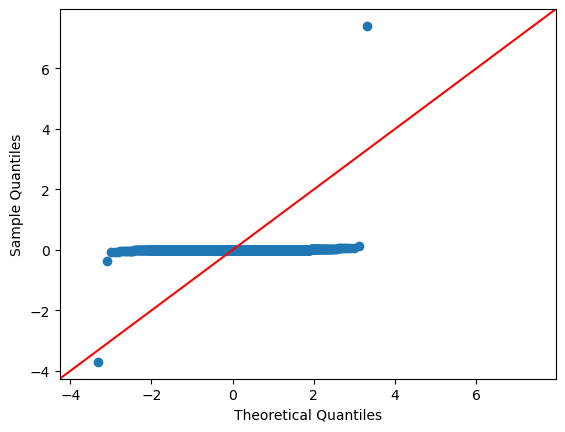

(178012360.78050497, 0.0, 28.564590627757884, 1424.127718676677)


In [31]:
# Normality

sm.qqplot(resid, line='45'); plt.show()
print(sm.stats.stattools.jarque_bera(resid))

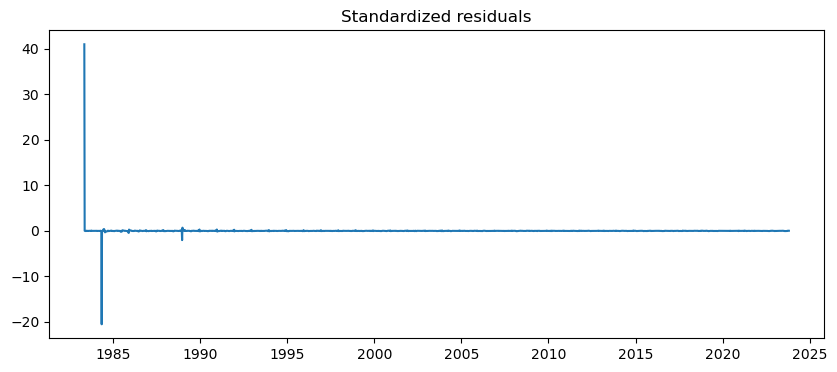

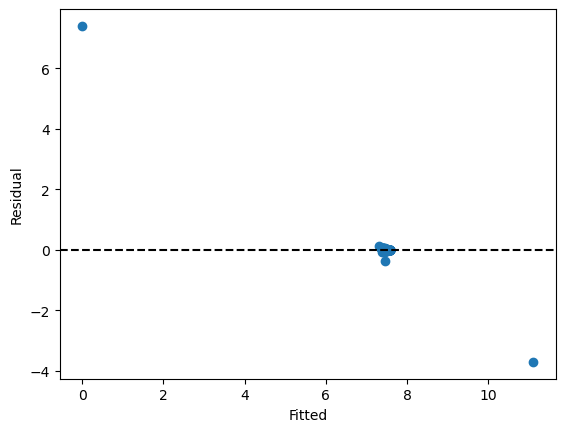

In [32]:
# Check forecast calibration

fitted = CH4_model_results.fittedvalues
std_resid = resid / resid.std()
plt.figure(figsize=(10,4))
plt.plot(std_resid)
plt.title('Standardized residuals')
plt.show()

plt.scatter(fitted, resid)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Fitted'); plt.ylabel('Residual')
plt.show()

B. Consider alternative differencing / seasonal treatment

If you have D=1 seasonal differencing and the seasonal component is weak, it might introduce extra variance. Test models with D=0 + seasonal dummies or Fourier terms (in SARIMAX) instead.

Use seasonal regressors (sine/cosine or Fourier terms) instead of heavy seasonal differencing to reduce forecast variance.

Example: add Fourier terms (from statsmodels.tsa.statespace.sarimax exog):

Why: Fourier terms capture seasonality with fewer parameters and may reduce variance blow-up from seasonal differencing.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
# create Fourier features function (k pairs)
def fourier_series(index, m=52, K=3):
    t = np.arange(len(index))
    X = np.column_stack([np.sin(2*np.pi*(k+1)*t/m) for k in range(K)] +
                        [np.cos(2*np.pi*(k+1)*t/m) for k in range(K)])
    return pd.DataFrame(X, index=index)

exog = fourier_series(ch4_preprocessed.index, m=52, K=3)
model = SARIMAX(np.log(ch4_preprocessed), order=(7,1,0), seasonal_order=(1,1,1,52), exog=exog)
res = model.fit(disp=False)
print(res.summary())

4) If diagnostics indicate heteroscedasticity (ARCH): consider SARIMA + GARCH

If het_arch test shows significance, fit a GARCH model on SARIMA residuals (or a joint SARIMA–GARCH model). Example pipeline:

Fit SARIMA on mean (maybe with exogs),

Model residuals with GARCH(1,1) or EGARCH to capture conditional volatility,

Simulate forecast distribution by combining mean forecasts and GARCH vol forecasts (gives better-tail CI).

You can use arch package:


Interpretation:
GARCH will produce time-varying forecast variances that may better match observed heteroscedasticity and produce more realistic CIs.

In [ ]:
from arch import arch_model
resid = CH4_model_results.resid.dropna()
garch = arch_model(resid, vol='Garch', p=1, q=1, dist='Studentst').fit(update_freq=5)
print(garch.summary())
# Use garch.forecast(...) to get conditional variances for combining into CIs


=== Residual Diagnostics Comparison ===


n    mean     std     Skew       Kurt  LjungBox_p@52  \
In-sample      2112.0  0.0017  0.1804  28.5849  1424.5007            0.0   
Out-of-sample    63.0 -0.0000  0.0047  -1.0209     0.1583            0.0   

               ARCH_p    JB_p  
In-sample      1.0000  0.0000  
Out-of-sample  0.0002  0.0054

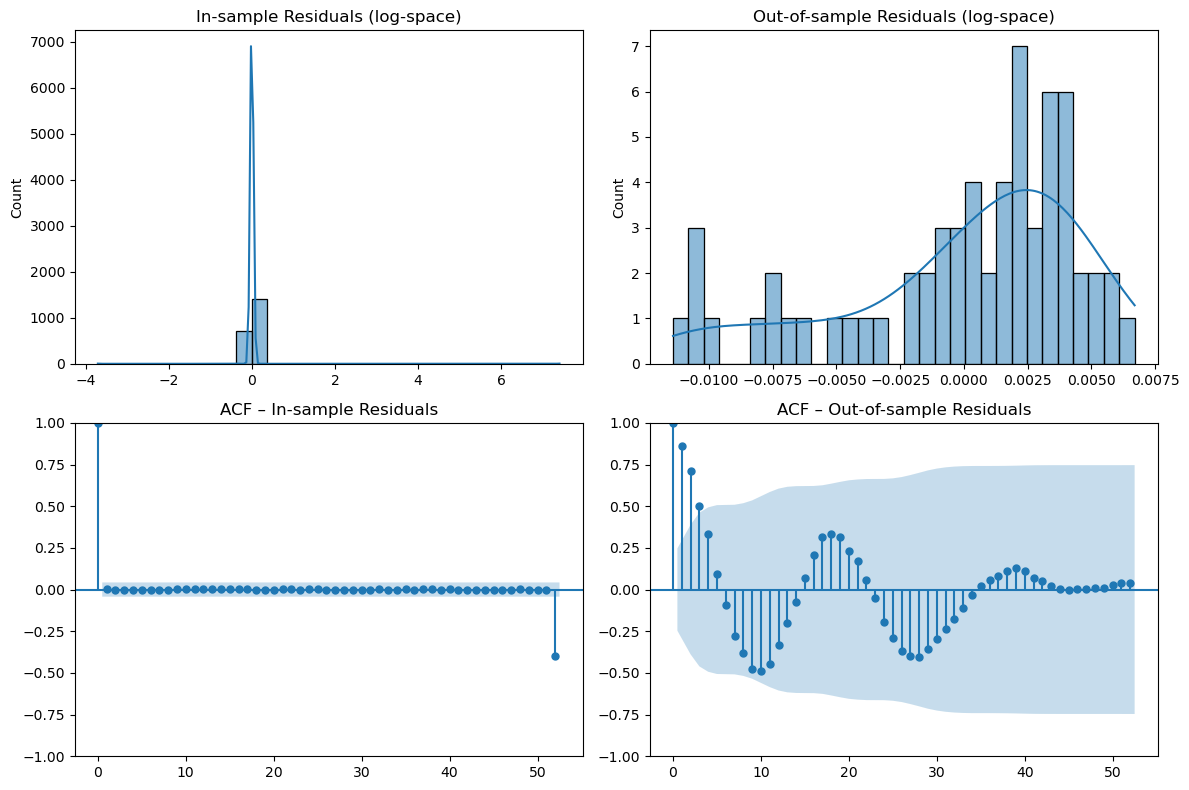

In [52]:
from statsmodels.stats.diagnostic import het_arch
from scipy import stats
import seaborn as sns

# ---- user-provided objects (adjust names if needed) ----
# CH4_model_results : fitted full SARIMA results (log space)
# CH4_train_preprocessed : training series (log space)
# CH4_test_preprocessed  : test series (log space)
order = (7,1,0)
seasonal_order = (1,1,1,52)

# ---------------------------------------------------------
# Ensure test is a Series with same index as forecast
if isinstance(CH4_test_log_preprocessed, pd.DataFrame):
    CH4_test_log_preprocessed = CH4_test_log_preprocessed.squeeze()

# ---------------------------------------------------------
# In-sample residuals from full model (already in log-space)
in_resid = CH4_model_results.resid.dropna()
if isinstance(in_resid, pd.DataFrame):
    in_resid = in_resid.squeeze()

# ---------------------------------------------------------
# Fit SARIMA on training set (log space)
model_train = SARIMAX(
    CH4_train_log_preprocessed,
    order=order,
    seasonal_order=seasonal_order,
    trend='c',
    enforce_stationarity=True,
    enforce_invertibility=True
).fit(method='powell', disp=False)

# ---------------------------------------------------------
# Generate out-of-sample forecast (still in log space)
fc = model_train.get_forecast(steps=len(CH4_test_log_preprocessed))
out_fore = fc.predicted_mean

# Reindex forecast to align with test set
out_fore = out_fore.reindex(CH4_test_log_preprocessed.index)

# Compute out-of-sample residuals (log-space)
out_resid = CH4_test_log_preprocessed - out_fore

# Defensive squeeze
if hasattr(out_resid, "ndim") and out_resid.ndim == 2:
    out_resid = out_resid.iloc[:, 0]

# ---------------------------------------------------------
# Residual diagnostics
def diag_summary(name, resid):
    resid = pd.Series(resid).dropna().astype(float)
    lb = acorr_ljungbox(resid, lags=[1,5,10,52], return_df=True)
    arch = het_arch(resid, nlags=12)
    jb = stats.jarque_bera(resid)
    return pd.Series({
        "n": len(resid),
        "mean": resid.mean(),
        "std": resid.std(),
        "Skew": resid.skew(),
        "Kurt": resid.kurtosis(),
        "LjungBox_p@52": lb.loc[52, "lb_pvalue"] if 52 in lb.index else np.nan,
        "ARCH_p": arch[1],
        "JB_p": jb[1]
    }, name=name)

summary = pd.concat([
    diag_summary("In-sample", in_resid),
    diag_summary("Out-of-sample", out_resid)
], axis=1)

print("\n=== Residual Diagnostics Comparison ===")
display(summary.T.round(4))

# ---------------------------------------------------------
# Quick diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(in_resid, bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title("In-sample Residuals (log-space)")

sns.histplot(out_resid, bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title("Out-of-sample Residuals (log-space)")

plot_acf(in_resid, lags=52, ax=axes[1,0])
axes[1,0].set_title("ACF – In-sample Residuals")

plot_acf(out_resid, lags=52, ax=axes[1,1])
axes[1,1].set_title("ACF – Out-of-sample Residuals")

plt.tight_layout()
plt.show()

In [53]:
in_resid.abs().nlargest(5)

date
1983-05-08    7.400811
1984-05-06    3.702924
1988-12-18    0.365030
1988-12-25    0.128340
1985-11-24    0.080953
dtype: float64

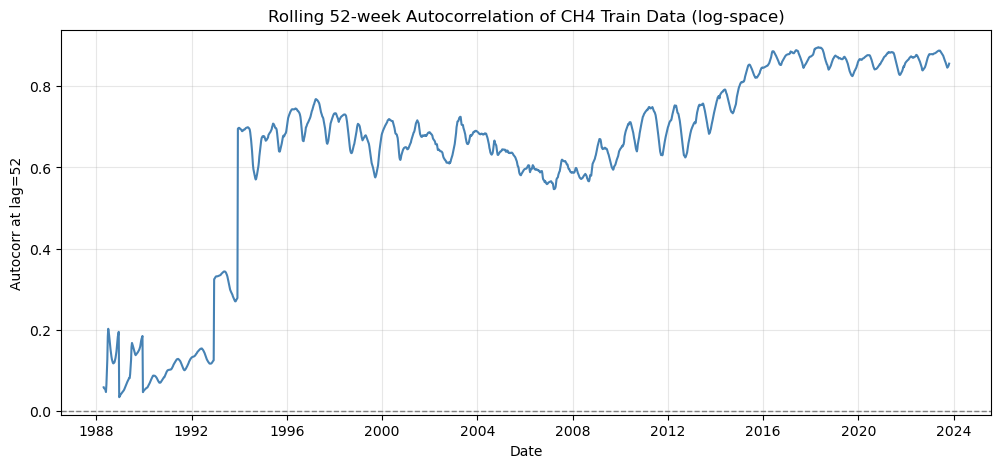

In [56]:
# assume CH4_log_preprocessed is your full log-transformed CH₄ series
# and indexed by weekly datetime

def rolling_autocorr(series, lag, window):
    """Compute rolling autocorrelation for a given lag and window length."""
    return series.rolling(window).apply(lambda x: x.autocorr(lag=lag), raw=False)

# 5-year (≈260 weeks) rolling window for stability
roll_ac52 = rolling_autocorr(CH4_train_log_preprocessed, lag=52, window=260)

plt.figure(figsize=(12,5))
plt.plot(roll_ac52, color='steelblue')
plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.title("Rolling 52-week Autocorrelation of CH4 Train Data (log-space)")
plt.ylabel("Autocorr at lag=52")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.show()

from ChatGPT:

Raw CH₄ (log-space) Series – Rolling lag-52 autocorr

Pattern: Steady increase in seasonal strength from ~0.3 (early years) to ~0.9 (post-2015).

Interpretation:
The 52-week (annual) seasonality became more coherent and stronger over time.
- In the late 1980s–1990s, the seasonal cycle was weak or irregular.
- Around 2010–2020, it stabilized into a highly periodic annual pattern.

This means your SARIMA’s fixed seasonal term (constant φ₅₂, θ₅₂) is trying to model a seasonal structure that was not constant historically.

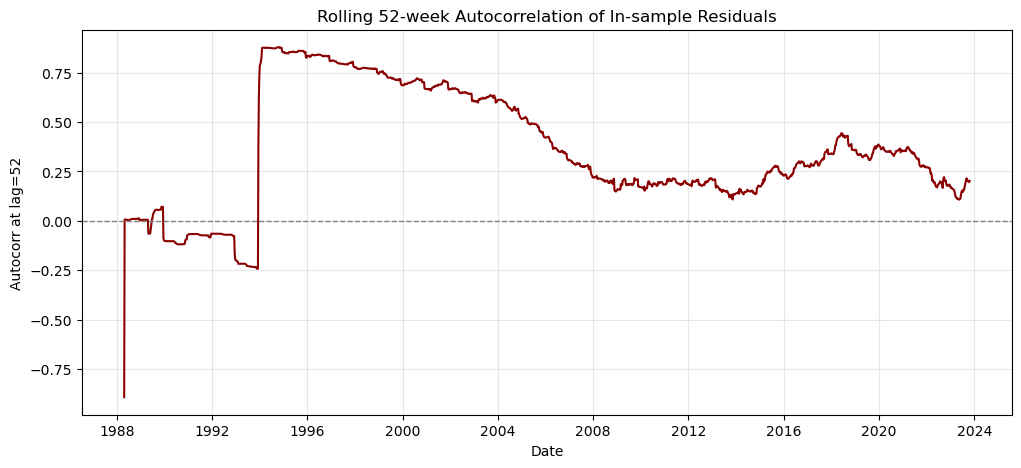

In [57]:
roll_resid_ac52 = rolling_autocorr(in_resid, lag=52, window=260)

plt.figure(figsize=(12,5))
plt.plot(roll_resid_ac52, color='darkred')
plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.title("Rolling 52-week Autocorrelation of In-sample Residuals")
plt.ylabel("Autocorr at lag=52")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.show()

from ChatGPT:

Residuals – Rolling lag-52 autocorr

Pattern: Very strong autocorrelation (~0.8) early on → gradual decline to ~0.2–0.3 by mid-2000s, with mild recovery later.

Interpretation:
- The SARIMA(7,1,0)(1,1,1,52) model initially underfit the seasonal cycle — residuals still carried a strong lag-52 signal (bad sign).
- Over time, that lag-52 correlation weakened as the model “fit” the dominant seasonality more effectively — but it still fluctuates.
- The residuals’ lag-52 autocorr never stays flat at 0 — so there’s persistent time-varying seasonality, not pure noise.

In [59]:
# formally test the trend in seasonal strength

valid = roll_resid_ac52.dropna()
trend_model = sm.OLS(valid.values, sm.add_constant(range(len(valid)))).fit()
print(trend_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     15.04
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           0.000109
Time:                        16:50:20   Log-Likelihood:                -376.13
No. Observations:                1853   AIC:                             756.3
Df Residuals:                    1851   BIC:                             767.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4013      0.014     29.133      0.0

In [36]:
# Look at parameter stability

print(CH4_model_results.params)
print(CH4_model_results.bse)

intercept   -0.000003
ar.L1       -0.643393
ar.L2       -0.459188
ar.L3       -0.333390
ar.L4       -0.283472
ar.L5       -0.229782
ar.L6       -0.157437
ar.L7       -0.102372
ar.S.L52    -0.026701
ma.S.L52    -0.923301
sigma2       0.000106
dtype: float64
intercept    0.000070
ar.L1        0.002748
ar.L2        0.005459
ar.L3        0.008563
ar.L4        0.015505
ar.L5        0.014363
ar.L6        0.013033
ar.L7        0.008512
ar.S.L52     0.006372
ma.S.L52     0.013696
sigma2       0.000001
dtype: float64


AttributeError: 'SARIMAXResults' object has no attribute 'plot_forecast_errors'

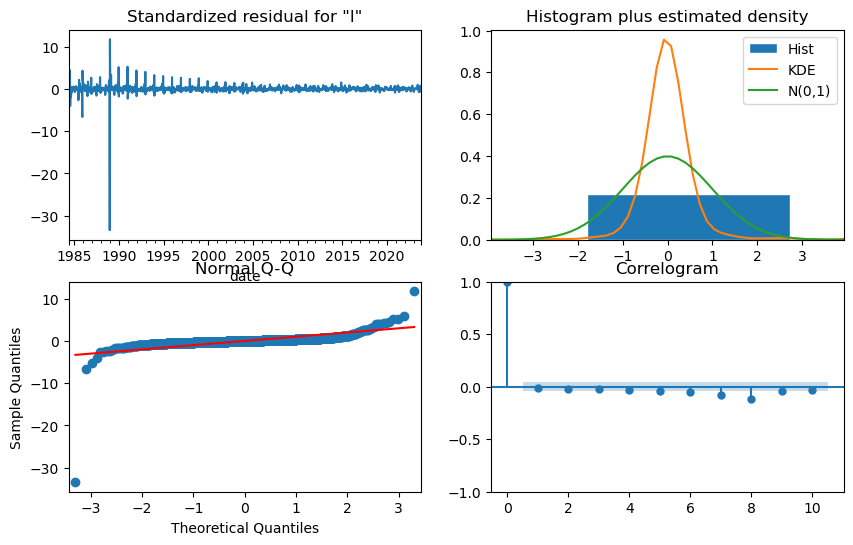

In [37]:
CH4_model_results.plot_diagnostics(figsize=(10,6))
CH4_model_results.plot_forecast_errors(100)

In [82]:
def fourier_series(index, m=52, K=3):
    t = np.arange(len(index))
    X = np.column_stack([np.sin(2*np.pi*(k+1)*t/m) for k in range(K)] +
                        [np.cos(2*np.pi*(k+1)*t/m) for k in range(K)])
    return pd.DataFrame(X, index=index, columns=[f'sin{k+1}' for k in range(K)] + [f'cos{k+1}' for k in range(K)])

exog = fourier_series(CH4_train_log_preprocessed.index, m=52, K=4)
model = SARIMAX(CH4_train_log_preprocessed, order=(7,1,0), seasonal_order=(0,0,0,0), exog=exog)
res = model.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                log_ch4   No. Observations:                 2112
Model:               SARIMAX(7, 1, 0)   Log Likelihood                6703.992
Date:                Wed, 15 Oct 2025   AIC                         -13375.984
Time:                        19:21:59   BIC                         -13285.505
Sample:                    05-08-1983   HQIC                        -13342.853
                         - 10-22-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin1          -0.0055      0.002     -2.792      0.005      -0.009      -0.002
sin2           0.0027      0.001      2.329      0.020       0.000       0.005
sin3           0.0001      0.001      0.189      0.850      -0.001       0.002
sin4          -0.0004      0.001     -0.662      0.508      -0.002       0.001
cos1           0.0015      0.002      0.740      0.459      -0.003       0.006
cos2           0.0024      0.001      2.647      0.008       0.001       0.004
cos3          -0.0010      0.001     -1.005      0.315      -0.003       0.001
cos4          -0.0002      0.001     -0.224      0.823      -0.002       0.001
ar.L1         -0.6454      0.005   -133.769      0.000      -0.655      -0.636
ar.L2         -0.4599      0.008    -54.681      0.000      -0.476      -0.443
ar.L3         -0.3386      0.011    -29.912      0.000      -0.361      -0.316
ar.L4         -0.2719      0.014    -18.995      0.000      -0.300      -0.244
ar.L5         -0.2143      0.014    -14.815      0.000      -0.243      -0.186
ar.L6         -0.1483      0.013    -11.378      0.000      -0.174      -0.123
ar.L7         -0.0980      0.008    -11.762      0.000      -0.114      -0.082
sigma2         0.0001   7.49e-07    136.126      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):          60579208.89
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                           -21.49
Prob(H) (two-sided):                  0.00   Kurtosis:                       831.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

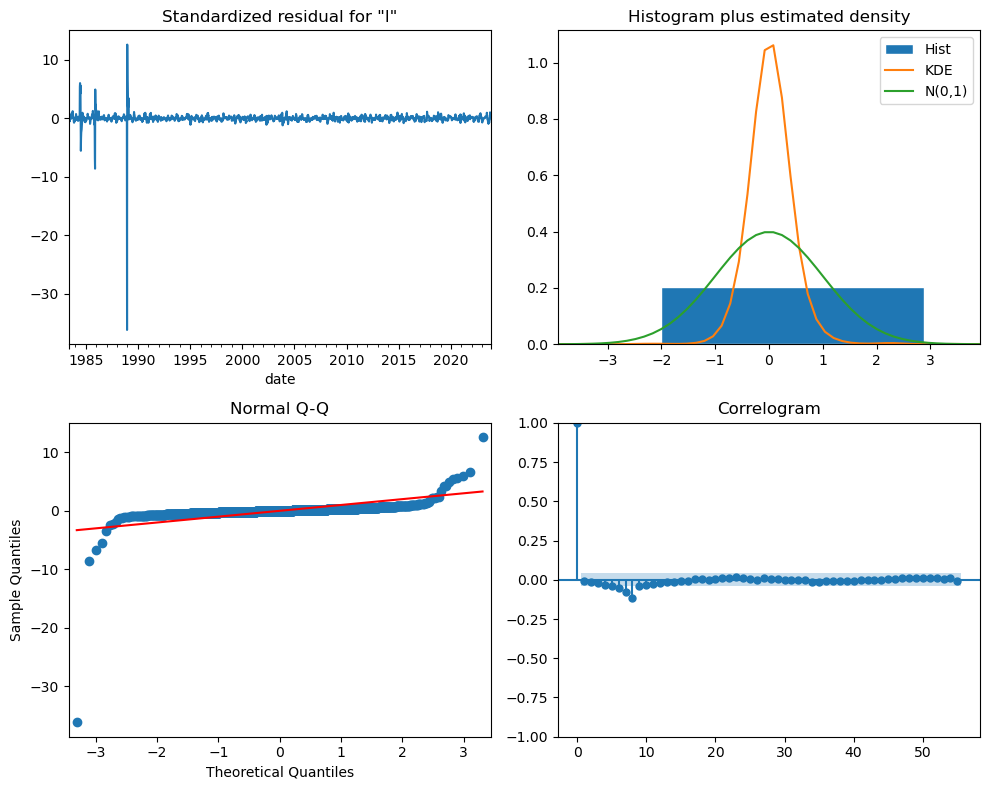

In [83]:
res.plot_diagnostics(figsize=(10,8), lags=55)
plt.tight_layout()
plt.show()

## Rolling Forecast

In [30]:
print(CH4_train_log_preprocessed.index.freq)
print(CH4_test_log_preprocessed.index.freq)
print(CH4_train_preprocessed.index.freq)
print(CH4_test_preprocessed.index.freq)

<Week: weekday=6>
<Week: weekday=6>
<Week: weekday=6>
<Week: weekday=6>


In [24]:
# rolling forecast SARIMA(1,1,0)(1,0,0)[52]

# Initialize variables
CH4_train_log_preprocessed.index.freq = 'W-SUN'
CH4_test_log_preprocessed.index.freq = 'W-SUN'
CH4_train_preprocessed.index.freq = 'W-SUN'
CH4_test_preprocessed.index.freq = 'W-SUN'

history = CH4_train_log_preprocessed['log_ch4_ppb'].copy()  # initial training data, ensure 1D input
rolling_forecasts = []
rolling_conf_ints = []

# Rolling forecast loop
for t in range(len(CH4_test_preprocessed)):
    # Fit the model on the current history
    model = SARIMAX(history, order=(1,1,0), seasonal_order=(1,0,0,52), trend='n')
    model_fit = model.fit(method='lbfgs', disp=False)
    
    # Forecast one step ahead
    forecast_result = model_fit.get_forecast(steps=1)
    
    # get the correct timestamp for the forecast
    forecast_index = CH4_test_preprocessed.index[t]
    
    # store the forecast and confidence intervals with explicit index
    forecast_mean = np.exp(forecast_result.predicted_mean.values[0])
    conf_int = np.exp(forecast_result.conf_int().values[0])
    
    # store the forecast and confident intervals with explicit index
    rolling_forecasts.append(pd.Series(forecast_mean, index=[forecast_index]))
    rolling_conf_ints.append(pd.DataFrame([[conf_int[0], conf_int[1]]], columns=['lower', 'upper'], index=[forecast_index]))
    
    # Update history with the actual observed test value (log-transformed)
    new_observation = CH4_test_log_preprocessed['log_ch4_ppb'].iloc[t]  # Still logged
    history = pd.concat([
        history, 
        pd.Series([new_observation], index=[CH4_test_preprocessed.index[t]])
        ])
    history = history.asfreq('W-SUN')  # Ensure the frequency is consistent 

# Convert to pandas Series/DataFrame
CH4_rolling_forecast = pd.concat(rolling_forecasts)
CH4_rolling_conf_int = pd.concat(rolling_conf_ints)

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packag

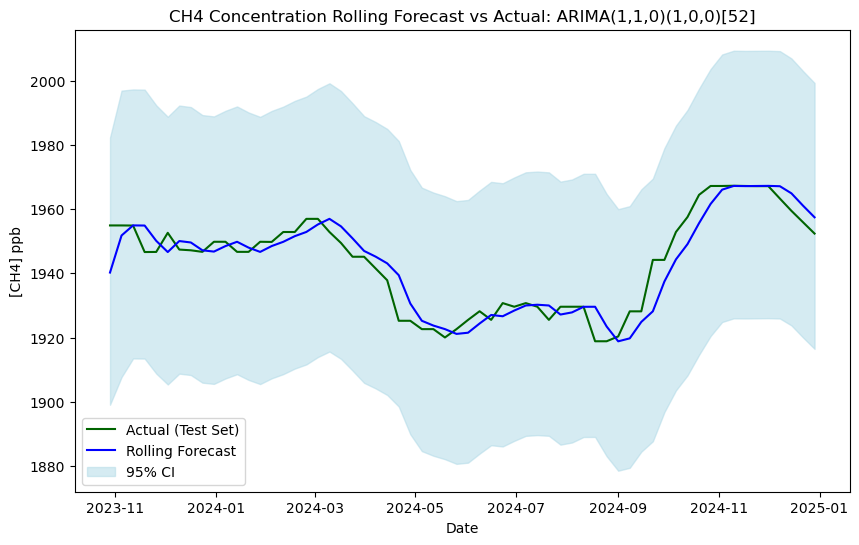

In [26]:
# plot the rolling forecast results 

plt.figure(figsize=(10,6))
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed, label='Actual (Test Set)', color='darkgreen') 
plt.plot(CH4_rolling_forecast.index, CH4_rolling_forecast, label='Rolling Forecast', color='blue') 
plt.fill_between(
    CH4_rolling_conf_int.index, 
    CH4_rolling_conf_int['lower'], 
    CH4_rolling_conf_int['upper'], 
    color='lightblue', alpha=0.5, label='95% CI'
)
plt.legend()
plt.title('CH4 Concentration Rolling Forecast vs Actual: ARIMA(1,1,0)(1,0,0)[52]') 
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.show()

In [27]:
# evaluation metrics for rolling forecast of SARIMA(1,1,0)(1,0,0)[52]

print('Min and Max values of the CH4 test set to help interpret evaluation metrics')
print('(units = ppb)\n')
print('Min:', round(CH4_test_preprocessed.min(),3))
print('Max:', round(CH4_test_preprocessed.max(),3))
print('Range:', round(CH4_test_preprocessed.max() - CH4_test_preprocessed.min(),3))

print('\nEvaluation Metrics for Rolling Forecast, SARIMA(1,1,0)(1,0,0,52)')  
forecast_metrics(CH4_test_preprocessed, CH4_rolling_forecast)

Min and Max values of the CH4 test set to help interpret evaluation metrics
(units = ppb)

Min: CH4    1918.85
dtype: float64
Max: CH4    1967.268
dtype: float64
Range: CH4    48.418
dtype: float64

Evaluation Metrics for Rolling Forecast, SARIMA(1,1,0)(1,0,0,52)


{'MAE': 3.967, 'MSE': 28.089, 'RMSE': 5.3, 'MAPE': 0.204}

### Autocorrelation analysis of rolling forecast model residuals

In [28]:
# Calculate the residuals from the rolling forecast models 

# SARIMA(1,1,0)(1,0,0)[52]
CH4_rolling_forecast_residuals = (np.exp(CH4_test_log_preprocessed['log_ch4_ppb']) - CH4_rolling_forecast)
CH4_rolling_forecast_residuals = pd.Series(
    CH4_rolling_forecast_residuals, 
    index=CH4_test_preprocessed.index
)

PACF function uses the Yule-Walker method to calculate the partial autocorrelation function (OLS method).  To avoid overfitting and ensure numerical stability, statsmodels enforces that # lags < 50% of the # observations. Since my test set is 67 data points in length, I am limited to 32 lags.  Two possible ways forward with the residuals test for autocorrelation:

1. move forward as is and interpret ACF based on 52 lags and PACF based on 32 lags.  
2. Go back and change the test set to include 106 data points (nlags < len(residuals) // 2).  

I will choose option 1 and determine if I need to change the data split ratio after I see the results.

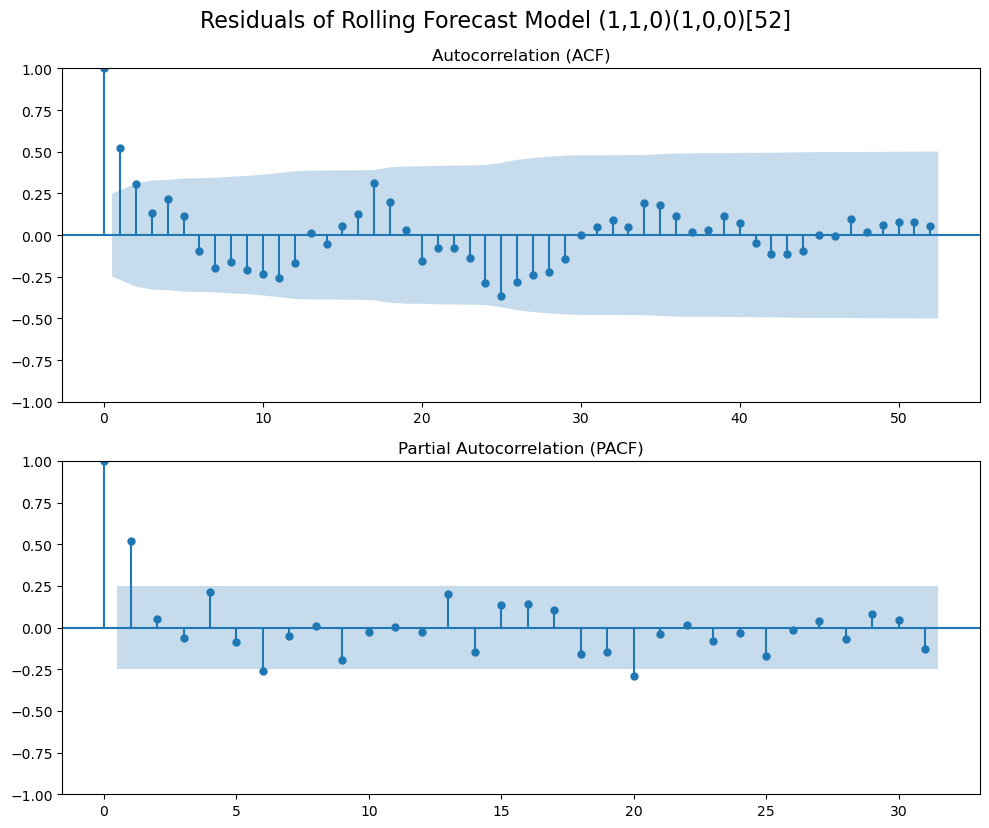

In [30]:
fig, axs = plt.subplots(2,1, figsize=(10,8))

plot_acf(
    CH4_rolling_forecast_residuals, 
    lags=52, 
    ax=axs[0],
    title='Autocorrelation (ACF)'
)

plot_pacf(
    CH4_rolling_forecast_residuals, 
    lags=31, 
    ax=axs[1],
    title='Partial Autocorrelation (PACF)'
)

plt.tight_layout()
plt.suptitle('Residuals of Rolling Forecast Model (1,1,0)(1,0,0)[52]', fontsize=16, y=1.03)
plt.show()

All lags are within the CI (95%) so aren't significant, but the pattern suggests that there is possible room to improve the model tune.  

In [31]:
# Ljung-Box test

lb_test = acorr_ljungbox(CH4_rolling_forecast_residuals, lags=[1,4,26,52], return_df=True)
    
print('Ljung-Box Test Results for SARIMA(1,1,0)(1,0,0)[52] Rolling Forecast Model\n')
print(lb_test)

Ljung-Box Test Results for SARIMA(1,1,0)(1,0,0)[52] Rolling Forecast Model

       lb_stat     lb_pvalue
1    17.562461  2.780229e-05
4    28.134149  1.171591e-05
26  100.856454  9.242086e-11
52  149.275936  2.463158e-11


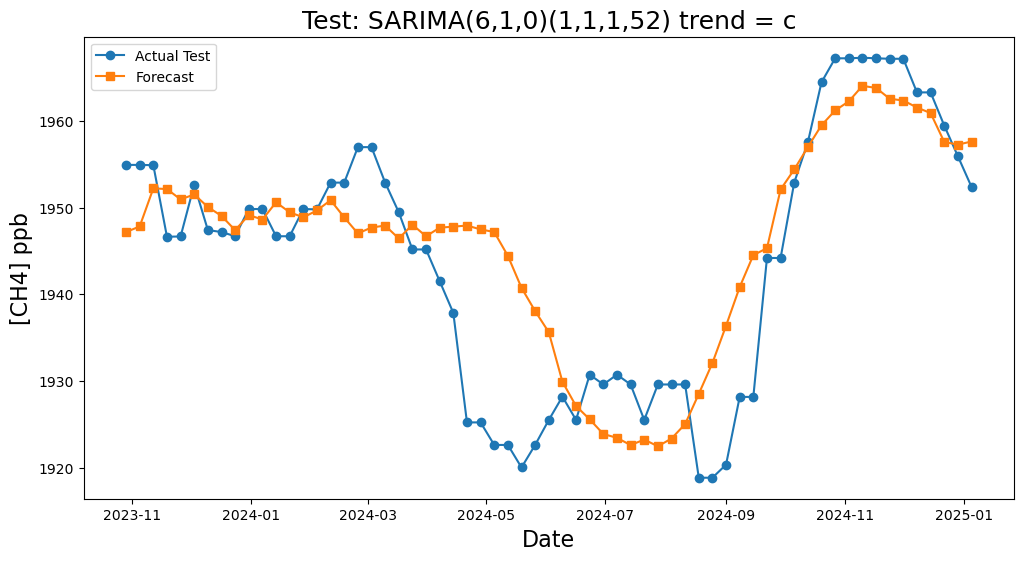

In [105]:
# Manually evaluate model parameters

test_model = SARIMAX(
    CH4_train_log_preprocessed,
    order=(6,1,0),
    seasonal_order=(1,1,1,52),
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)
test_results = test_model.fit(disp=False)

# Check if this gives you a seasonal forecast
forecast = test_results.get_forecast(steps=len(CH4_test_preprocessed))
forecast_values = np.exp(forecast.predicted_mean)

# Plot to see if it's still a straight line
plt.figure(figsize=(12,6))
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed.values, label='Actual Test', marker='o')
plt.plot(forecast_values.index, forecast_values.values, label='Forecast', marker='s')
plt.legend()
plt.title('Test: SARIMA(6,1,0)(1,1,1,52) trend = c', fontsize=18)
plt.ylabel('[CH4] ppb', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

In [107]:
print('Evaluation Metrics for SARIMA(6,1,0)(1,1,1,52) Forecast')  
forecast_metrics(CH4_test_preprocessed, forecast_values)


Evaluation Metrics for SARIMA(6,1,0)(1,1,1,52) Forecast


{'MAE': 6.456, 'MSE': 78.43, 'RMSE': 8.856, 'MAPE': 0.334}

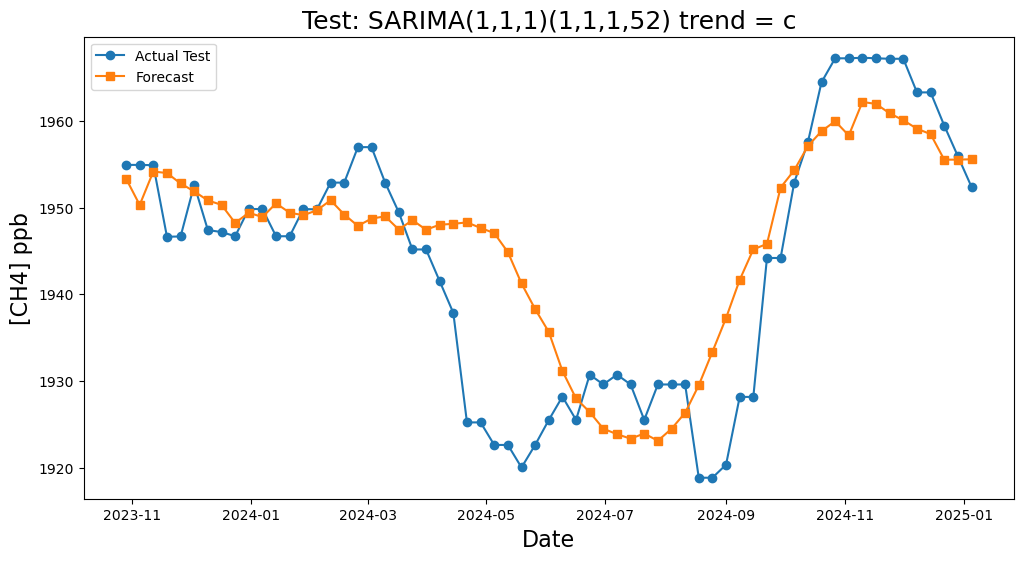

In [17]:
test_model = SARIMAX(
    CH4_train_log_preprocessed,
    order=(1,1,1),
    seasonal_order=(1,1,1,52),
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)
test_results = test_model.fit(disp=False)

# Check if this gives you a seasonal forecast
forecast = test_results.get_forecast(steps=len(CH4_test_preprocessed))
forecast_values = np.exp(forecast.predicted_mean)

# Plot to see if it's still a straight line
plt.figure(figsize=(12,6))
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed.values, label='Actual Test', marker='o')
plt.plot(forecast_values.index, forecast_values.values, label='Forecast', marker='s')
plt.legend()
plt.title('Test: SARIMA(1,1,1)(1,1,1,52) trend = c', fontsize=18)
plt.ylabel('[CH4] ppb', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

In [18]:
print('Evaluation Metrics for SARIMA(1,1,1)(1,1,1,52) Forecast')  
forecast_metrics(CH4_test_preprocessed, forecast_values)


Evaluation Metrics for SARIMA(1,1,1)(1,1,1,52) Forecast


{'MAE': 6.651, 'MSE': 82.387, 'RMSE': 9.077, 'MAPE': 0.344}

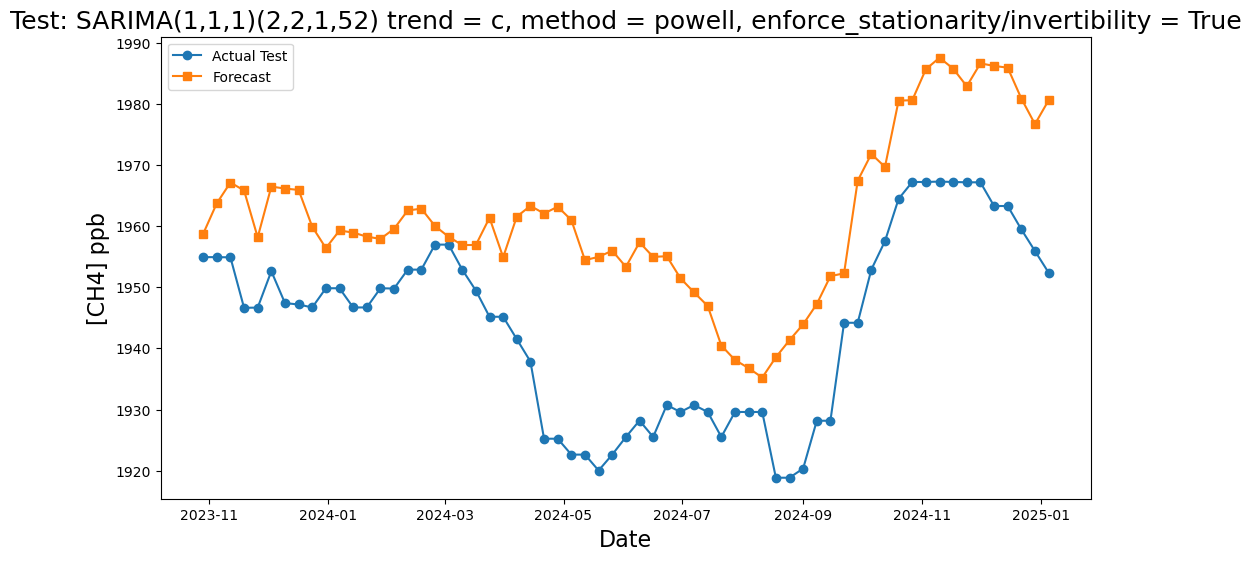

In [97]:
test_model = SARIMAX(
    CH4_train_log_preprocessed,
    order=(1,1,1),
    seasonal_order=(2,2,1,52),
    trend='c',
)
test_results = test_model.fit(disp=False, method='powell')

# Check if this gives you a seasonal forecast
forecast = test_results.get_forecast(steps=len(CH4_test_preprocessed))
forecast_values = np.exp(forecast.predicted_mean)

# Plot to see if it's still a straight line
plt.figure(figsize=(12,6))
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed.values, label='Actual Test', marker='o')
plt.plot(forecast_values.index, forecast_values.values, label='Forecast', marker='s')
plt.legend()
plt.title('Test: SARIMA(1,1,1)(2,2,1,52) trend = c, method = powell, enforce_stationarity/invertibility = True', fontsize=18)
plt.ylabel('[CH4] ppb', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

In [95]:
print('Evaluation Metrics for SARIMA(1,1,1)(2,2,1,52) Forecast (trend = c, method = powell, enforce_stationarity/invertibility = True)')  
forecast_metrics(CH4_test_preprocessed, forecast_values)

Evaluation Metrics for SARIMA(3,1,0)(0,2,2,52) Forecast (trend = c, method = powell, enforce_stationarity/invertibility = True)


{'MAE': 15.719, 'MSE': 356.698, 'RMSE': 18.886, 'MAPE': 0.81}

SARIMA(1,1,0)(1,1,1,52) 
trend = n
{'MAE': 7.17, 'MSE': 111.773, 'RMSE': 10.572, 'MAPE': 0.371} 
trend = c
{'MAE': 6.965, 'MSE': 92.866, 'RMSE': 9.637, 'MAPE': 0.36} ****
trend = t
{'MAE': 10.589, 'MSE': 171.306, 'RMSE': 13.088, 'MAPE': 0.547}
trend = ct
{'MAE': 10.657, 'MSE': 172.866, 'RMSE': 13.148, 'MAPE': 0.55}

SARIMA(1,1,0)(0,1,0,52), trend = c
{'MAE': 12.151, 'MSE': 248.787, 'RMSE': 15.773, 'MAPE': 0.627}
SARIMA(1,1,0)(0,1,1,52), trend = c
{'MAE': 7.236, 'MSE': 92.802, 'RMSE': 9.633, 'MAPE': 0.373} 
SARIMA(1,1,0)(1,1,0,52), trend = c
{'MAE': 8.688, 'MSE': 134.877, 'RMSE': 11.614, 'MAPE': 0.449}
SARIMA(1,1,0)(1,1,1,52), trend = c, method = powell, enforce_stationarity/enforce_invertibility = True
{'MAE': 7.177, 'MSE': 108.106, 'RMSE': 10.397, 'MAPE': 0.371}

SARIMA(1,1,1)(0,1,0,52), trend = c
{'MAE': 10.657, 'MSE': 172.866, 'RMSE': 13.148, 'MAPE': 0.55}
SARIMA(1,1,1)(1,1,0,52), trend = c
{'MAE': 12.17, 'MSE': 217.456, 'RMSE': 14.746, 'MAPE': 0.628}
SARIMA(1,1,1)(0,1,1,52), trend = c
{'MAE': 8.429, 'MSE': 97.537, 'RMSE': 9.876, 'MAPE': 0.433} 
SARIMA(1,1,1)(0,1,1,52), trend = c, method = powell, enforce_stationarity/enforce_invertibility = True
{'MAE': 6.743, 'MSE': 95.21, 'RMSE': 9.758, 'MAPE': 0.349}

SARIMA(1,1,1)(1,1,1,52), trend = c, enforce_stationarity/enforce_invertibility = False
{'MAE': 6.651, 'MSE': 82.387, 'RMSE': 9.077, 'MAPE': 0.344} **
SARIMA(1,1,1)(1,1,1,52), trend = c, enforce_stationarity/enforce_invertibility = True
{'MAE': 6.564, 'MSE': 85.489, 'RMSE': 9.246, 'MAPE': 0.339}
SARIMA(1,1,1)(1,1,1,52), trend = c, method = powell, enforce_stationarity/enforce_invertibility = True
{'MAE': 6.703, 'MSE': 96.146, 'RMSE': 9.805, 'MAPE': 0.347}
SARIMA(1,1,1)(1,1,1,52), trend = n, method = powell, enforce_stationarity/enforce_invertibility = True
{'MAE': 6.732, 'MSE': 98.315, 'RMSE': 9.915, 'MAPE': 0.348}

SARIMA(1,1,1)(2,1,1,52), trend = c, method = powell, enforce_stationarity/enforce_invertibility = True
{'MAE': 6.804, 'MSE': 98.244, 'RMSE': 9.912, 'MAPE': 0.352}
SARIMA(1,1,1)(1,1,2,52), trend = c, method = powell, enforce_stationarity/enforce_invertibility = True
{'MAE': 6.699, 'MSE': 94.914, 'RMSE': 9.742, 'MAPE': 0.346}

SARIMA(2,1,0)(1,1,0,52), trend = c
{'MAE': 9.399, 'MSE': 149.143, 'RMSE': 12.212, 'MAPE': 0.485}
SARIMA(2,1,0)(0,1,1,52), trend = c
{'MAE': 7.012, 'MSE': 94.7, 'RMSE': 9.731, 'MAPE': 0.362} 
SARIMA(2,1,0)(1,1,2,52), trend = c
{'MAE': 6.975, 'MSE': 94.76, 'RMSE': 9.734, 'MAPE': 0.36} *****
    
SARIMA(2,1,0)(1,1,1,52)
trend = c
{'MAE': 6.919, 'MSE': 90.132, 'RMSE': 9.494, 'MAPE': 0.357} ***
trend = n
{'MAE': 7.071, 'MSE': 108.493, 'RMSE': 10.416, 'MAPE': 0.366} 
trend = t
{'MAE': 11.093, 'MSE': 183.309, 'RMSE': 13.539, 'MAPE': 0.573}
trend = ct
{'MAE': 11.231, 'MSE': 186.66, 'RMSE': 13.662, 'MAPE': 0.58}
SARIMA(2,1,0)(1,1,1,52), trend = c, method = powell, enforce_stationarity/invertibility = True
{'MAE': 7.088, 'MSE': 105.319, 'RMSE': 10.263, 'MAPE': 0.366}

SARIMA(2,1,1)(0,1,0,52), trend = c
{'MAE': 12.151, 'MSE': 248.787, 'RMSE': 15.773, 'MAPE': 0.627}
SARIMA(2,1,1)(1,1,1,52), trend = c
{'MAE': 7.232, 'MSE': 81.826, 'RMSE': 9.046, 'MAPE': 0.373} 
SARIMA(2,1,1)(1,1,1,52), trend = c, method = powell, enforce_stationarity/invertibility = True
{'MAE': 6.73, 'MSE': 96.133, 'RMSE': 9.805, 'MAPE': 0.348}

SARIMA(2,1,1)(2,1,1,52), trend = c, method = powell, enforce_stationarity/invertibility = True
{'MAE': 6.808, 'MSE': 98.006, 'RMSE': 9.9, 'MAPE': 0.352}

SARIMA(3,1,0)(1,1,1,52), trend = c
{'MAE': 6.886, 'MSE': 93.132, 'RMSE': 9.65, 'MAPE': 0.356}
SARIMA(3,1,0)(1,1,1,52), trend = c, enforce_stationarity/invertibility = True
{'MAE': 6.87, 'MSE': 97.2, 'RMSE': 9.859, 'MAPE': 0.355}
SARIMA(3,1,0)(1,1,1,52), trend = c, method = powell, enforce_stationarity/invertibility = True
{'MAE': 7.072, 'MSE': 104.749, 'RMSE': 10.235, 'MAPE': 0.366}


SARIMA(3,1,1)(1,1,1,52), trend = c, method = lbfgs, enforce_stationarity/invertibility = False 
{'MAE': 6.929, 'MSE': 81.174, 'RMSE': 9.01, 'MAPE': 0.358}
SARIMA(3,1,1)(1,1,1,52), trend = c, method = lbfgs, enforce_stationarity/invertibility = True
{'MAE': 6.616, 'MSE': 84.804, 'RMSE': 9.209, 'MAPE': 0.342} 
SARIMA(3,1,1)(1,1,1,52), trend = c, method = bfgs, enforce_stationarity/invertibility = True
{'MAE': 6.732, 'MSE': 95.163, 'RMSE': 9.755, 'MAPE': 0.348}
SARIMA(3,1,1)(1,1,1,52), trend = c, method = powell, enforce_stationarity/invertibility = True
{'MAE': 6.736, 'MSE': 96.223, 'RMSE': 9.809, 'MAPE': 0.348}
SARIMA(3,1,1)(1,1,1,52), trend = n, method = powell, enforce_stationarity/invertibility = True
{'MAE': 6.738, 'MSE': 96.394, 'RMSE': 9.818, 'MAPE': 0.348}
SARIMA(3,1,1)(1,1,1,52), trend = c, method = nm, enforce_stationarity/invertibility = True
{'MAE': 10.386, 'MSE': 166.794, 'RMSE': 12.915, 'MAPE': 0.536}
SARIMA(3,1,1)(1,1,1,52), trend = c, method = cg, enforce_stationarity/invertibility = True
{'MAE': 10.654, 'MSE': 172.97, 'RMSE': 13.152, 'MAPE': 0.55}

SARIMA(3,1,1)(2,1,1,52), trend = c, method = powell, enforce_stationarity/invertibility = True
{'MAE': 7.068, 'MSE': 96.947, 'RMSE': 9.846, 'MAPE': 0.365}
SARIMA(3,1,1)(1,1,2,52), trend = c, method = powell, enforce_stationarity/invertibility = True
{'MAE': 6.729, 'MSE': 94.624, 'RMSE': 9.728, 'MAPE': 0.348}
SARIMA(3,1,1)(2,1,2,52), trend = c, method = powell, enforce_stationarity/invertibility = True
{'MAE': 6.81, 'MSE': 97.402, 'RMSE': 9.869, 'MAPE': 0.352}


SARIMA(4,1,0)(1,1,1,52), trend = c
{'MAE': 6.862, 'MSE': 85.991, 'RMSE': 9.273, 'MAPE': 0.354}
SARIMA(5,1,0)(1,1,1,52), trend = c
{'MAE': 6.862, 'MSE': 85.991, 'RMSE': 9.273, 'MAPE': 0.354}
SARIMA(5,1,0)(2,1,1,52), trend = c
{'MAE': 6.862, 'MSE': 85.991, 'RMSE': 9.273, 'MAPE': 0.354}
SARIMA(6,1,0)(1,1,1,52), trend = c
{'MAE': 6.456, 'MSE': 78.43, 'RMSE': 8.856, 'MAPE': 0.334} *
SARIMA(6,1,0)(1,1,1,52), trend = c, enforce_stationarity/enforce_invertibility = True (but with convergence warnings)
{'MAE': 6.79, 'MSE': 79.129, 'RMSE': 8.895, 'MAPE': 0.35}
SARIMA(6,1,0)(1,1,1,52), trend = n
{'MAE': 6.752, 'MSE': 82.09, 'RMSE': 9.06, 'MAPE': 0.349}
SARIMA(6,1,0)(1,1,1,52), trend = t
{'MAE': 6.752, 'MSE': 82.09, 'RMSE': 9.06, 'MAPE': 0.349}
SARIMA(6,1,0)(1,1,0,52), trend = c
{'MAE': 9.014, 'MSE': 143.051, 'RMSE': 11.96, 'MAPE': 0.466}
SARIMA(6,1,0)(0,1,1,52), trend = c
{'MAE': 7.238, 'MSE': 83.094, 'RMSE': 9.116, 'MAPE': 0.373}
SARIMA(6,1,1)(1,1,1,52), trend = c
{'MAE': 6.793, 'MSE': 75.361, 'RMSE': 8.681, 'MAPE': 0.35}
SARIMA(7,1,0)(1,1,1,52), trend = c
{'MAE': 6.952, 'MSE': 77.853, 'RMSE': 8.823, 'MAPE': 0.359}
SARIMA(7,1,0)(1,1,2,52), trend = c, method = powell, enforce_stationarity/enforce_invertibility = True
{'MAE': 7.113, 'MSE': 80.525, 'RMSE': 8.974, 'MAPE': 0.367}

# Test the (1,1,0)(1,0,0,52) model with trend = 'c'

In [33]:
model_trendc = SARIMAX(
    CH4_train_log_preprocessed,
    order = (1,1,0),
    seasonal_order = (1,0,0,52),
    trend = 'ct',
    enforce_stationarity = False,
    enforce_invertibility = False
)

results_trendc = model_trendc.fit(disp = False)    
results_trendc.summary()

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            log_ch4   No. Observations:                 2112
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 52)   Log Likelihood                6349.224
Date:                            Thu, 02 Oct 2025   AIC                         -12688.448
Time:                                    17:20:49   BIC                         -12660.301
Sample:                                05-08-1983   HQIC                        -12678.128
                                     - 10-22-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.257      0.797      -0.001       0.001
drift       6.695e-09    8.8e-07      0.008      0.994   -1.72e-06    1.73e-06
ar.L1         -0.4266      0.001   -321.720      0.000      -0.429      -0.424
ar.S.L52       0.0097      0.067      0.146      0.884      -0.121       0.141
sigma2         0.0001   2.41e-07    496.169      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                  23.17   Jarque-Bera (JB):          37673024.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                           -13.00
Prob(H) (two-sided):                  0.00   Kurtosis:                       665.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
model_trendt = SARIMAX(
    CH4_train_log_preprocessed,
    order = (2,1,1),
    seasonal_order = (1,0,0,52),
    trend = 't',
    enforce_stationarity = False,
    enforce_invertibility = False
)

results_trendt = model_trendt.fit(disp = False)    
results_trendt.summary()

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         log_ch4_ppb   No. Observations:                 2111
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 52)   Log Likelihood                6453.142
Date:                             Wed, 01 Oct 2025   AIC                         -12894.284
Time:                                     17:55:58   BIC                         -12860.513
Sample:                                 05-08-1983   HQIC                        -12881.902
                                      - 10-15-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       5.163e-08    2.3e-07      0.225      0.822   -3.99e-07    5.02e-07
ar.L1          0.0212      0.017      1.275      0.202      -0.011       0.054
ar.L2         -0.0098      0.009     -1.053      0.292      -0.028       0.008
ma.L1         -0.5883      0.017    -34.332      0.000      -0.622      -0.555
ar.S.L52       0.0095      0.060      0.159      0.874      -0.107       0.126
sigma2         0.0001   2.71e-07    407.128      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   2.53   Jarque-Bera (JB):          47658213.94
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                           -18.85
Prob(H) (two-sided):                  0.00   Kurtosis:                       747.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
# forecast the CH4 best SARIMA model results: SARIMA(1,1,1)(0,0,0)[52], trend = 't', method = 'lbfgs'

# create the forecast object  
forecast_object2 = results_trendt.get_forecast(steps=len(CH4_test_preprocessed))

# get mean forecast and confidence intervals
forecast_logged = forecast_object2.predicted_mean
forecast_conf_int_logged= forecast_object2.conf_int()

# undo log (exponentiate), back-transform the logged values to original scale
forecast2 = np.exp(forecast_logged)
forecast_conf_int2 = np.exp(forecast_conf_int_logged)

# set the forecast index to match the test set index
forecast2.index = CH4_test_preprocessed.index
forecast_conf_int2.index = CH4_test_preprocessed.index

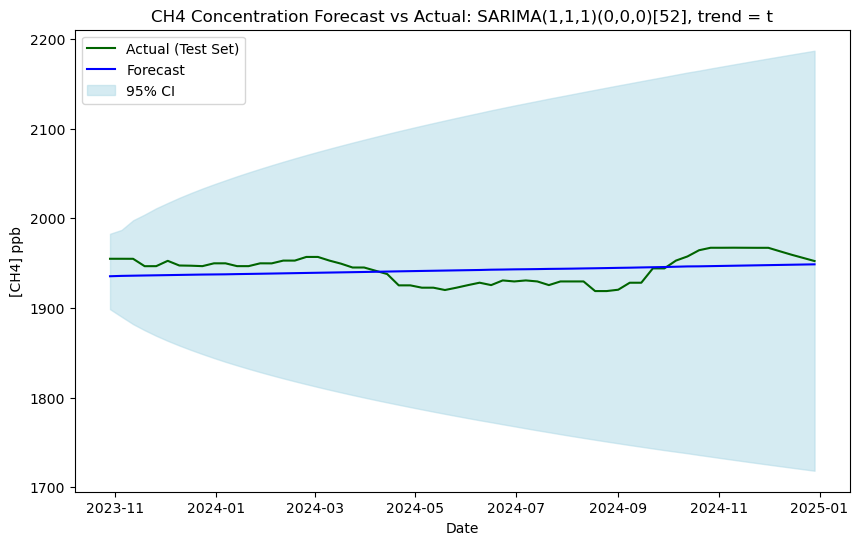

In [99]:
# focus on the forecast results

plt.figure(figsize=(10,6))
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed, label='Actual (Test Set)', color='darkgreen') 
plt.plot(forecast2.index, forecast2, label='Forecast', color='blue') 
plt.fill_between(
    forecast_conf_int.index, 
    forecast_conf_int.iloc[:, 0], 
    forecast_conf_int.iloc[:, 1], 
    color='lightblue', alpha=0.5, label='95% CI'
)
plt.legend()
plt.title('CH4 Concentration Forecast vs Actual: SARIMA(1,1,1)(0,0,0)[52], trend = t') 
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.show()

In [100]:
# Forecast metrics for model with trend = 't'

print('Min and Max values of the CH4 test set to help interpret evaluation metrics')
print('(units = ppb)\n')
print('Min:', round(CH4_test_preprocessed.min(),3))
print('Max:', round(CH4_test_preprocessed.max(),3))
print('Range:', round(CH4_test_preprocessed.max() - CH4_test_preprocessed.min(),3))

print('\nEvaluation Metrics for SARIMA Predication (1,1,1)(0,0,0,52), trend = t')  
forecast_metrics(CH4_test_preprocessed, forecast2)

Min and Max values of the CH4 test set to help interpret evaluation metrics
(units = ppb)

Min: CH4    1918.85
dtype: float64
Max: CH4    1967.268
dtype: float64
Range: CH4    48.418
dtype: float64

Evaluation Metrics for SARIMA Predication (1,1,1)(0,0,0,52), trend = t


{'MAE': 13.98, 'MSE': 228.794, 'RMSE': 15.126, 'MAPE': 0.72}

In [ ]:
Min and Max values of the CH4 test set to help interpret evaluation metrics
(units = ppb)

Min: CH4    1918.85
dtype: float64
Max: CH4    1967.268
dtype: float64
Range: CH4    48.418
dtype: float64

Evaluation Metrics for SARIMA Predication (1,1,0)(1,0,0,52), trend = c
{'MAE': 13.437, 'MSE': 220.413, 'RMSE': 14.846, 'MAPE': 0.692}

# CH4 forecasting

## Load the full, preprocessed dataset

In [25]:
CH4_preprocessed = pd.read_csv(
    '../data/processed/ch4_preprocessed.csv',
    parse_dates=['date'], 
    index_col='date'
)

CH4_preprocessed.index = pd.DatetimeIndex(CH4_preprocessed.index, freq='W-SUN')

## Re-train the model on the full dataset

In [26]:
print(CH4_preprocessed.index.freq)
print(CH4_preprocessed.index.min())
print(CH4_preprocessed.index.max())

<Week: weekday=6>
1983-05-08 00:00:00
2025-04-06 00:00:00


### Log transform and save as CSV

In [27]:
# log transform the entire dataset
CH4_preprocessed_logged = np.log(CH4_preprocessed) 

In [28]:
# define output path
from pathlib import Path

output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

In [29]:
# save the logged full CH4 dataset (CH4_preprocessed)
output_path = output_dir / 'ch4_preprocessed_logged.csv'
(
    CH4_preprocessed_logged
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

print(f'CH4_preprocessed_logged data saved to:\n{output_path}')
print(f'Shape: {CH4_preprocessed_logged.shape}')

CH4_preprocessed_logged data saved to:
..\data\processed\ch4_preprocessed_logged.csv
Shape: (2188, 1)


C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                     CH4   No. Observations:                 2188
Model:             SARIMAX(2, 1, 0)x(1, 0, [1, 2], 52)   Log Likelihood                9362.643
Date:                                 Wed, 11 Jun 2025   AIC                         -18713.286
Time:                                         18:19:21   BIC                         -18679.439
Sample:                                     05-08-1983   HQIC                        -18700.883
                                          - 04-06-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0701      0.016      4.316      0.000       0.038       0

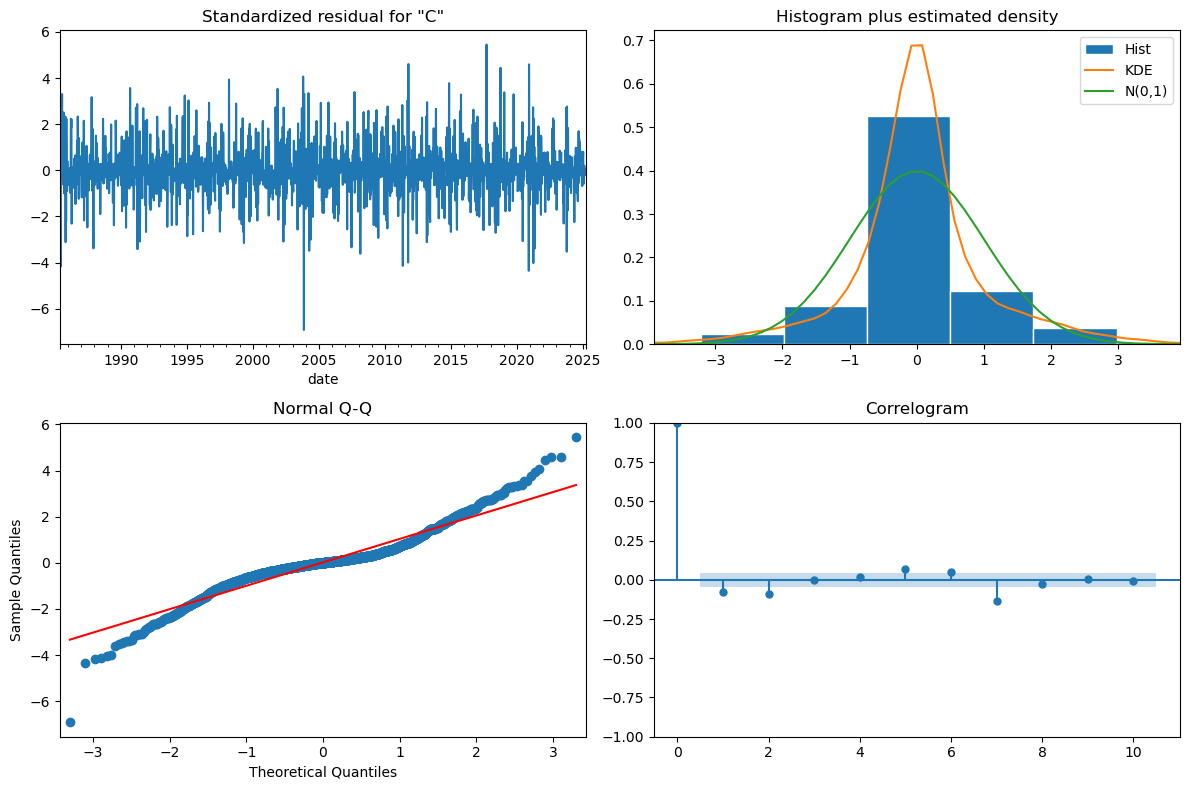

In [139]:
# I will re-train the SARIMA(2,1,0)(1,0,2)[52] model with the entire dataset 

CH4_final_model = SARIMAX(CH4_preprocessed_logged, 
                          order=(2,1,0),
                          seasonal_order=(1,0,2,52),
                          trend='n',
                          enforce_stationarity=False,
                          enforce_invertibility=False
)         

CH4_final_model_fit = CH4_final_model.fit(method='lbfgs', disp=False)                   
diag_fig = CH4_final_model_fit.plot_diagnostics(figsize=(12, 8))   

print(CH4_final_model_fit.summary())
plt.tight_layout()
plt.show(diag_fig)

Full dataset model residual diagnostics look acceptable overall:

positives:
- AIC = -18713, BIC = -18679, which are good, low values
- Heteroscedasticity (H and prob(H)) suggest no issues with volatility
- all coefficients are statistically significant
- Standardized residuals: random, no clear patterns

negatives:
- The Jarque-Bera test and QQ plot shows non-normal distribution with heavy tails
- Ljung-Box test shows that some autocorrelation remains, and can be seen at lag 1, mayb lag 2 of the correlogram



                                        SARIMAX Results                                        
Dep. Variable:                                     CH4   No. Observations:                 2188
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2], 52)   Log Likelihood                9383.164
Date:                                 Wed, 11 Jun 2025   AIC                         -18752.329
Time:                                         18:28:18   BIC                         -18712.844
Sample:                                     05-08-1983   HQIC                        -18737.860
                                          - 04-06-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0258      0.164      0.157      0.875      -0.296       0

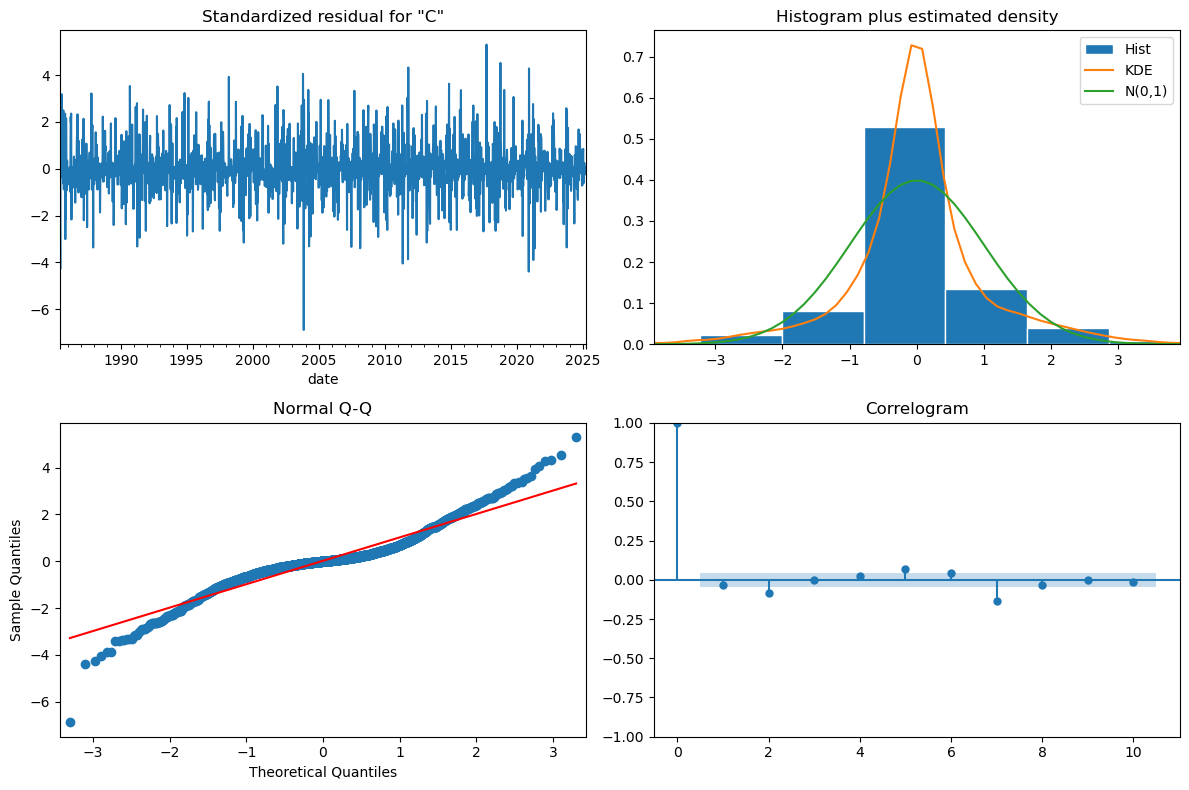

In [140]:
# I will try adding a non-seasonal MA term to address the autocorrelation observed at lag 1
# SARIMA(2,1,1)(1,0,2)[52]

CH4_final_model = SARIMAX(CH4_preprocessed_logged, 
                          order=(2,1,1),
                          seasonal_order=(1,0,2,52),
                          trend='n',
                          enforce_stationarity=False,
                          enforce_invertibility=False
)         

CH4_final_model_fit = CH4_final_model.fit(method='lbfgs', disp=False)                   
diag_fig = CH4_final_model_fit.plot_diagnostics(figsize=(12, 8))   

print(CH4_final_model_fit.summary())
plt.tight_layout()
plt.show(diag_fig)

                                        SARIMAX Results                                        
Dep. Variable:                                     CH4   No. Observations:                 2188
Model:             SARIMAX(1, 1, 0)x(1, 0, [1, 2], 52)   Log Likelihood                9445.101
Date:                                 Wed, 11 Jun 2025   AIC                         -18880.202
Time:                                         18:36:45   BIC                         -18851.997
Sample:                                     05-08-1983   HQIC                        -18869.867
                                          - 04-06-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0490      0.016     -2.999      0.003      -0.081      -0

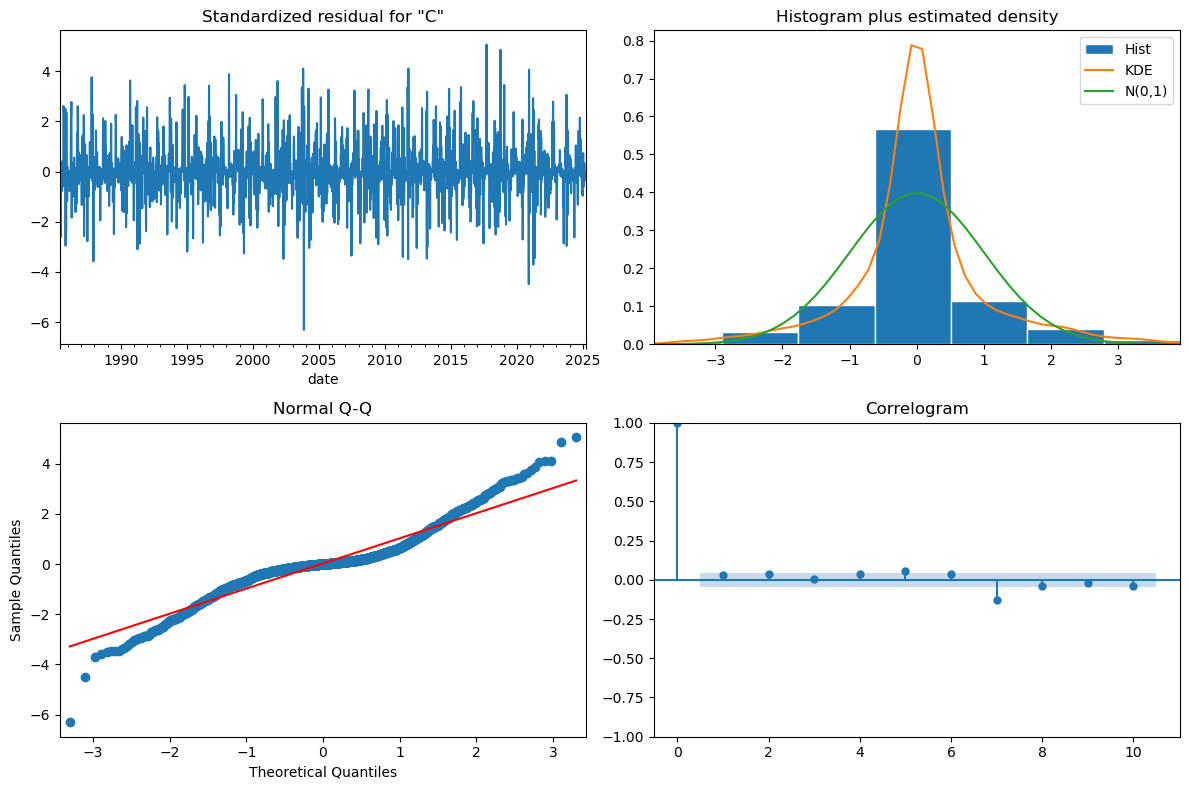

In [141]:
# adding the non-seasonal MA(1) term improved the model by eliminating the autocorrelation and lag 1, 
# increasing the log likelihood, and decreasing both AIC and BIC values.  However, now, non-seasonal terms 
# ar(L1) and ma(l1) became statistically insignificant.  
# SARIMA(1,1,0)(1,0,2)[52]

CH4_final_model = SARIMAX(CH4_preprocessed_logged, 
                          order=(1,1,0),
                          seasonal_order=(1,0,2,52),
                          trend='n',
                          enforce_stationarity=False,
                          enforce_invertibility=False
)         

CH4_final_model_fit = CH4_final_model.fit(method='lbfgs', disp=False)                   
diag_fig = CH4_final_model_fit.plot_diagnostics(figsize=(12, 8))   

print(CH4_final_model_fit.summary())
plt.tight_layout()
plt.show(diag_fig)

Full dataset model residual diagnostics look acceptable overall:

positives:
- log-likelihood increased from 9362 to 9445
- AIC decreased from -18713 to -18880
- BIC decreased from -18679 to -18852
- Heteroscedasticity (H and prob(H)) suggest no issues with volatility
- Standardized residuals: random, no clear patterns
- Ljung-Box test and correlogram present homoscedastic behavior

negatives:
- the seasonal AR term (AR.S.L52) is not statistically significant.  However, removing this term (i.e. (1,1,0)(0,0,[1,2])[52]) produced substantially worse metrics, data histogram, QQ plot and correlogram.  
- The Jarque-Bera test and QQ plot still shows non-normal distribution with heavy tails

The SARIMA(1,1,0)(1,0,2)[52] is a better and more simple model compared to SARIMA(2,1,0)(1,0,2)[52] on the full dataset.  

## Test New Parameters on Train & Test Sets

In [142]:
# Rolling forecast loop for SARIMA(1,1,0)(1,0,2)[52]

# Initialize variables
CH4_train_logged.index.freq = 'W-SUN'
CH4_test_logged.index.freq = 'W-SUN'
CH4_train_preprocessed.index.freq = 'W-SUN'
CH4_test_preprocessed.index.freq = 'W-SUN'

history = CH4_train_logged['log_ch4_ppb'].copy()  # Your initial training data, ensure 1D input
rolling_forecasts = []
rolling_conf_ints = []

for t in range(len(CH4_test_preprocessed)):
    # Fit the model on the current history
    model = SARIMAX(history, order=(1,1,0), seasonal_order=(1,0,2,52), trend='n')
    model_fit = model.fit(method='lbfgs', disp=False)
    
    # Forecast one step ahead
    forecast_result = model_fit.get_forecast(steps=1)
    
    # get the correct timestamp for the forecast
    forecast_index = CH4_test_preprocessed.index[t]
    
    # store the forecast and confidence intervals with explicit index
    forecast_mean = np.exp(forecast_result.predicted_mean.values[0])
    conf_int = np.exp(forecast_result.conf_int().values[0])
    
    # store the forecast and confident intervals with explicit index
    rolling_forecasts.append(pd.Series(forecast_mean, index=[forecast_index]))
    rolling_conf_ints.append(pd.DataFrame([[conf_int[0], conf_int[1]]], columns=['lower', 'upper'], index=[forecast_index]))
    
    # Update history with the actual observed test value (log-transformed)
    new_observation = CH4_test_logged['log_ch4_ppb'].iloc[t]  # Still logged
    history = pd.concat([
        history, 
        pd.Series([new_observation], index=[CH4_test_preprocessed.index[t]])
        ])
    history = history.asfreq('W-SUN')  # Ensure the frequency is consistent 

# Convert to pandas Series/DataFrame
CH4_rolling_forecast = pd.concat(rolling_forecasts)
CH4_rolling_conf_int = pd.concat(rolling_conf_ints)

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packag

In [143]:
# verify the order and seasonal order
print('"CH4_best_model": SARIMA(1,1,0)(1,0,2)[52]')
print('Order (p, d, q):', model_fit.model.order)
print('Seasonal order (P, D, Q, s):', model_fit.model.seasonal_order)

"CH4_best_model": SARIMA(1,1,0)(1,0,2)[52]
Order (p, d, q): (1, 1, 0)
Seasonal order (P, D, Q, s): (1, 0, 2, 52)


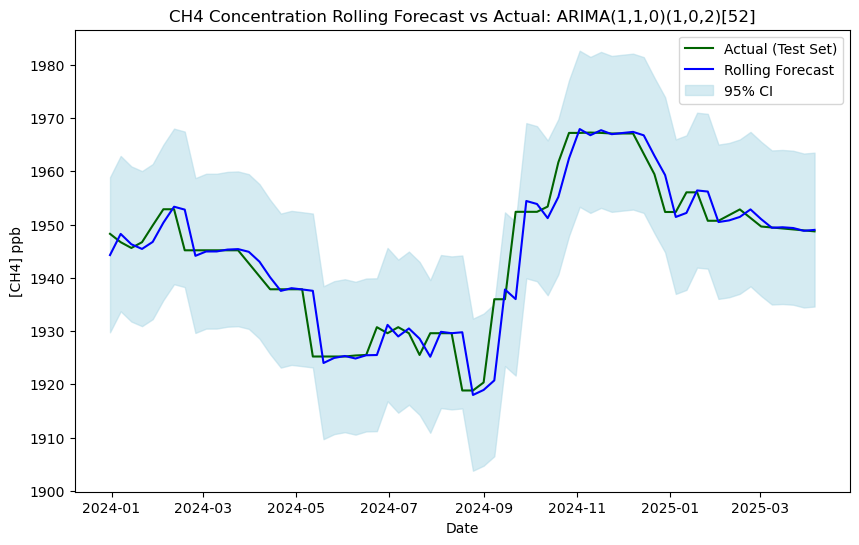

In [144]:
# plot the rolling forecast results for SARIMA(1,1,0)(1,0,2)[52]

plt.figure(figsize=(10,6))
plt.plot(CH4_test_preprocessed.index, CH4_test_preprocessed, label='Actual (Test Set)', color='darkgreen') 
plt.plot(CH4_rolling_forecast.index, CH4_rolling_forecast, label='Rolling Forecast', color='blue') 
plt.fill_between(
    CH4_rolling_conf_int.index, 
    CH4_rolling_conf_int['lower'], 
    CH4_rolling_conf_int['upper'], 
    color='lightblue', alpha=0.5, label='95% CI'
)
plt.legend()
plt.title('CH4 Concentration Rolling Forecast vs Actual: ARIMA(1,1,0)(1,0,2)[52]') 
plt.xlabel('Date')
plt.ylabel('[CH4] ppb')
plt.show()

In [145]:
# Evaluation metrics for rolling forecast of SARIMA(1,1,0)(1,0,2)[52]

print('Min and Max values of the CH4 test set to help interpret evaluation metrics')
print('(units = ppb)\n')
print('Min:', round(CH4_test_preprocessed.min(),3))
print('Max:', round(CH4_test_preprocessed.max(),3))
print('Range:', round(CH4_test_preprocessed.max() - CH4_test_preprocessed.min(),3))

print('\nEvaluation Metrics for Rolling Forecast, SARIMA(1,1,0)(1,0,2,52)')  
forecast_metrics(CH4_test_preprocessed, CH4_rolling_forecast)

Min and Max values of the CH4 test set to help interpret evaluation metrics
(units = ppb)

Min: CH4    1918.85
dtype: float64
Max: CH4    1967.268
dtype: float64
Range: CH4    48.418
dtype: float64

Evaluation Metrics for Rolling Forecast, SARIMA(1,1,0)(1,0,2,52)


{'MAE': 2.378, 'MSE': 17.302, 'RMSE': 4.16, 'MAPE': 0.122, 'R-squared': 0.903}

**Compare SARIMA(1,1,0)(1,0,2,52) vs SARIMA(2,1,0)(1,0,2,52)**

Evaluation Metrics for Rolling Forecast, SARIMA(2,1,0)(1,0,2,52):
- {'MAE': 2.438, 'MSE': 17.13, 'RMSE': 4.139, 'MAPE': 0.125, 'R-squared': 0.904}

The differences in evaluation metrics are minimal.  Considering that the simpler model has better log likelihood, AIC, and BIC scores and results in residuals that are homescedastic and no autocorrelation, SARIMA(1,1,0)(1,0,2,52) is the better model.    

# Save the Final Model Configuration

In [146]:
import json
from datetime import datetime

model_config = {
    'model_type': 'SARIMAX',
    'order': (1,1,0),
    'seasonal_order': (1,0,2,52),
    'trend': 'n',
    'enforce_stationarity': False,
    'envorce_invertibility': False,
    'training_date_range': {
        'start': CH4_preprocessed_logged.index[0].strftime('%Y-%m-%d'),
        'end': CH4_preprocessed_logged.index[-1].strftime('%Y-%m-%d')
    },
    'fit_method': 'lbfgs',
    'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# save as JSON file
with open('../results/CH4_full_dataset_best_model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

print('CH4 full dataset model configuration saved.  Re-fit in next notebook.')

CH4 full dataset model configuration saved.  Re-fit in next notebook.
